In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2
import pei.myfunctions as mf
from xhistogram.xarray import histogram
from dask.diagnostics import ProgressBar
import time

# Points

In [5]:
years = np.arange(2000,2101)
fracs = {}
region='India'
for year in years:
    ds = xr.open_dataset('../data/processed/WBTyearly/WBT'+str(year)+'.nc')
    ds_region = mf.slice_region(ds,region)
    
    # Days greater than heat stress threshold
    ds_frac = (ds_region.sel(WBT_bin=slice(25,None)).sum(['ensemble','WBT_bin']))/1825
    fracs[year]=ds_frac['histogram_WBT']
    
ds_freq = xr.Dataset(fracs).to_array('year','Frequencies')

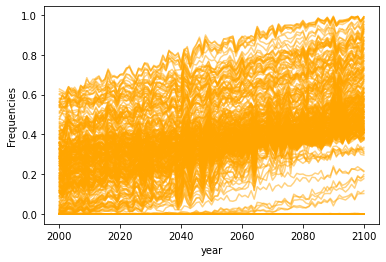

In [6]:
ds_freq_adj = ds_freq.stack(xy=('lon','lat'))

fig,ax = plt.subplots()
ds_freq_adj.plot.line(hue='xy',add_legend=False,color='orange',alpha=0.5,ax=ax);

In [10]:
# Load area data
land_area = xr.open_dataset('../data/processed/wbt.land_area')
land_mask = np.isfinite(land_area)
# Replace NaN with 0 
land_area_adj = land_area.where(land_mask,0).rename({'__xarray_dataarray_variable__':'land_area'})
land_area_adj = land_area_adj['land_area'].isel(ensemble=0)

area_region = mf.slice_region(land_area_adj,'India')

freq_avg = (ds_freq*area_region).sum(['lon','lat'])/area_region.sum()

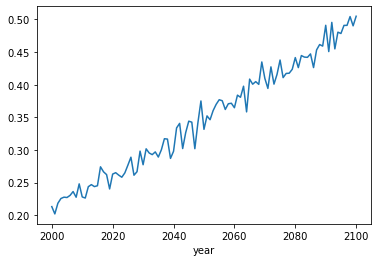

In [12]:
freq_avg.plot()

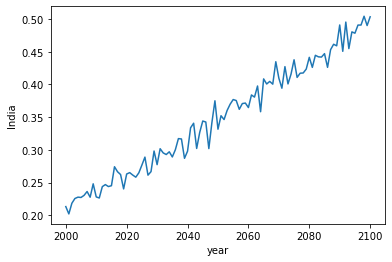

In [17]:
# Load binned WBT data
ds = xr.open_dataset('../data/processed/WBT_binned.nc')
ds_ind =ds['India'].sel(year=slice(2000,2101))
ds_ind = ds_ind/ds_ind.sum(['WBT_bin','ensemble'])
ds_ind.sel(WBT_bin=slice(25,None)).sum(['WBT_bin','ensemble']).plot()

# Looping Method

448.43199706077576


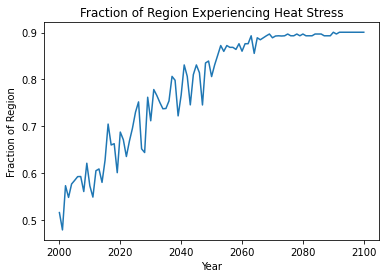

In [13]:
start_time = time.time()

# Load area data
land_area = xr.open_dataset('../data/processed/wbt.land_area')
land_mask = np.isfinite(land_area)
# Replace NaN with 0 
land_area_adj = land_area.where(land_mask,0).rename({'__xarray_dataarray_variable__':'land_area'})
land_area_adj = land_area_adj['land_area'].isel(ensemble=0)

region = 'India'
years = np.arange(2000,2101)
fracs = []
ds_area = mf.slice_region(land_area_adj,region)
total_area = ds_area.sum()

for year in years:
    ds = xr.open_dataset('../data/processed/WBTyearly/WBT'+str(year)+'.nc')
    ds_region = mf.slice_region(ds,region)
    
    # Days greater than heat stress threshold
    ds_frac = (ds_region.sel(WBT_bin=slice(25,None)).sum(['ensemble','WBT_bin']))
    
    # Boolean aray of grid cells exceeding desired frequency
    ds_hot = ds_frac >= (0.2*1825)
    
    # Area-weighted fraction of region
    frac = (ds_hot*ds_area).sum()/total_area
    
    # Add to array
    fracs.append(frac['histogram_WBT'].values.item())

fig, ax = plt.subplots()
ax.plot(years,fracs)
ax.set_xlabel('Year')
ax.set_ylabel('Fraction of Region')
ax.set_title('Fraction of Region Experiencing Heat Stress')
    
elapsed_time = time.time() - start_time
print(elapsed_time)

# Dask

In [3]:
# Load area data
land_area = xr.open_dataset('../data/processed/wbt.land_area')
land_mask = np.isfinite(land_area)
# Replace NaN with 0 
land_area_adj = land_area.where(land_mask,0).rename({'__xarray_dataarray_variable__':'land_area'})
land_area_adj = land_area_adj['land_area'].isel(ensemble=0)

region = 'India'
ds_area = mf.slice_region(land_area_adj,region)
total_area = ds_area.sum()

ds2 = xr.open_mfdataset('../data/processed/WBTyearly/WBT20*',combine='nested',concat_dim='year',chunks={'ensemble':1})

In [16]:
ds_region = mf.slice_region(ds2,region)
ds_frac = (ds_region.sel(WBT_bin=slice(25,None)).sum(['ensemble','WBT_bin']))/1825

In [17]:
frac = (ds_frac*ds_area).sum(['lat','lon'])/total_area

[########################################] | 100% Completed | 23.8s


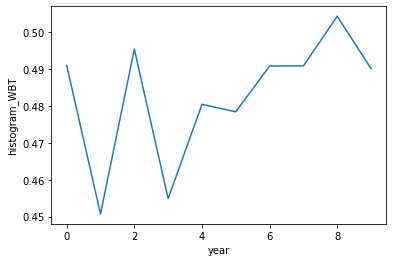

In [18]:
with ProgressBar():
    frac['histogram_WBT'].plot()

In [13]:
ds = xr.open_dataset('../data/processed/WBTyearly/WBT2091.nc')
    
# Days greater than heat stress threshold
%time ds_frac = (ds.sel(lat=slice(-40,40)).sel(WBT_bin=slice(25,None)).sum(['WBT_bin']))

CPU times: user 68 ms, sys: 559 ms, total: 627 ms
Wall time: 1min 13s


In [9]:
%time ds_frac2 = (ds.sel(WBT_bin=slice(27.9,None)).sum(['WBT_bin']))

CPU times: user 58 ms, sys: 401 ms, total: 459 ms
Wall time: 461 ms


In [10]:
%time ds_frac2 = (ds.sel(WBT_bin=slice(30,None)).sum(['WBT_bin']))

CPU times: user 40 ms, sys: 326 ms, total: 366 ms
Wall time: 368 ms
